In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Import utility functions
from utils import OLS, precompute_beta_ols, run_train_test_splits, results_to_dataframe, print_summary_statistics

In [2]:
# Load the COMPAS dataset
print("=" * 60)
print("Loading COMPAS data")
print("=" * 60)

df = pd.read_csv('./raw_data/compas-scores-two-years.csv')
df = df[['compas_screening_date', 'sex', 'race', 'v_decile_score', 'is_recid']]
df = df[df.race.isin(["African-American", "Caucasian", "Hispanic"])]

# Scale COMPAS score to [0, 1]
df['compas_score_scaled'] = df['v_decile_score'] / 10.0

df.compas_screening_date = pd.to_datetime(df.compas_screening_date)
df = df.sort_values(by='compas_screening_date')

# Prepare labels and COMPAS scores
y = df.is_recid.to_numpy().astype(float)
f = df.compas_score_scaled.to_numpy().astype(float)  # COMPAS score as predictor

# Get race and sex dummies for group analysis
dummy_df_races = pd.get_dummies(df.race)
dummy_df_sexes = pd.get_dummies(df.sex)
races = dummy_df_races.values.astype(float)
sexes = dummy_df_sexes.values.astype(float)
order_races = dummy_df_races.columns.values.tolist()
order_sexes = dummy_df_sexes.columns.values.tolist()

# Build feature matrix for debiasing: intercept + race dummies + sex dummies
# Note: NOT including COMPAS score in X since that's what we're debiasing
X = np.column_stack([
    np.ones(len(y)),                         # intercept
    dummy_df_races.values.astype(float),     # race dummies
    dummy_df_sexes.values.astype(float)      # sex dummies
])

feature_names = ['intercept'] + order_races + order_sexes

print(f"Loaded {len(y)} samples with {X.shape[1]} features")
print(f"Features: {feature_names}")
print(f"Recidivism rate (y): {y.mean():.4f}")
print(f"Mean COMPAS score (f): {f.mean():.4f}")
print(f"COMPAS score range: [{f.min():.2f}, {f.max():.2f}]")
print(f"Mean bias (f - y): {(f - y).mean():.4f}")
print(f"\nGroups - Races: {order_races}")
print(f"Groups - Sexes: {order_sexes}")

Loading COMPAS data
Loaded 6787 samples with 6 features
Features: ['intercept', 'African-American', 'Caucasian', 'Hispanic', 'Female', 'Male']
Recidivism rate (y): 0.4871
Mean COMPAS score (f): 0.3742
COMPAS score range: [0.10, 1.00]
Mean bias (f - y): -0.1129

Groups - Races: ['African-American', 'Caucasian', 'Hispanic']
Groups - Sexes: ['Female', 'Male']


In [3]:
# Compute bias and fit OLS models
bias = f - y

# Standard OLS (no conservative guarantee)
print("=" * 60)
print("Standard OLS (gamma = 0)")
print("=" * 60)
ols_standard = OLS(lam=0.01, gamma=0.0)
ols_standard.fit(X, bias)
bias_pred_standard = ols_standard.predict(X)
f_debiased_standard = f - bias_pred_standard

print(f"Fitted coefficients (θ): {ols_standard.theta}")
print(f"Mean bias: {bias.mean():.6f}")
print(f"Mean predicted bias: {bias_pred_standard.mean():.6f}")
print(f"Mean debiased prediction: {f_debiased_standard.mean():.6f}")

# Precompute beta for conservative OLS
print("\n" + "=" * 60)
print("Precomputing β (stability parameter)")
print("=" * 60)
print("Note: This uses bootstrap with leave-one-out. May take a few minutes...")
beta_hat = precompute_beta_ols(X, bias, lam=0.01, n_bootstrap=50) # With a large # of bootstrap samples, the estimate is 0.00256
print(f"Estimated β: {beta_hat:.6f}")

# Conservative OLS
print("\n" + "=" * 60)
print(f"Conservative OLS (gamma = β = {beta_hat:.6f})")
print("=" * 60)
ols_conservative = OLS(lam=0.01, gamma=beta_hat)
ols_conservative.fit(X, bias)
bias_pred_conservative = ols_conservative.predict(X)
f_debiased_conservative = f - bias_pred_conservative

print(f"Fitted coefficients (θ): {ols_conservative.theta}")
print(f"Mean predicted bias: {bias_pred_conservative.mean():.6f}")
print(f"Mean debiased prediction: {f_debiased_conservative.mean():.6f}")

Standard OLS (gamma = 0)
Fitted coefficients (θ): [-0.04941364 -0.02222616 -0.03558187  0.0083944  -0.00123376 -0.04817988]
Mean bias: -0.112878
Mean predicted bias: -0.112630
Mean debiased prediction: 0.486861

Precomputing β (stability parameter)
Note: This uses bootstrap with leave-one-out. May take a few minutes...
Estimated β: 0.000256

Conservative OLS (gamma = β = 0.000256)
Fitted coefficients (θ): [-0.04941364 -0.02222616 -0.03558187  0.0083944  -0.00123376 -0.04817988]
Mean predicted bias: -0.112630
Mean debiased prediction: 0.486861


Running 100 train-test splits...
Beta used for conservative method: 0.000256
Progress: 10...20...30...40...50...60...70...80...90...100... Done!


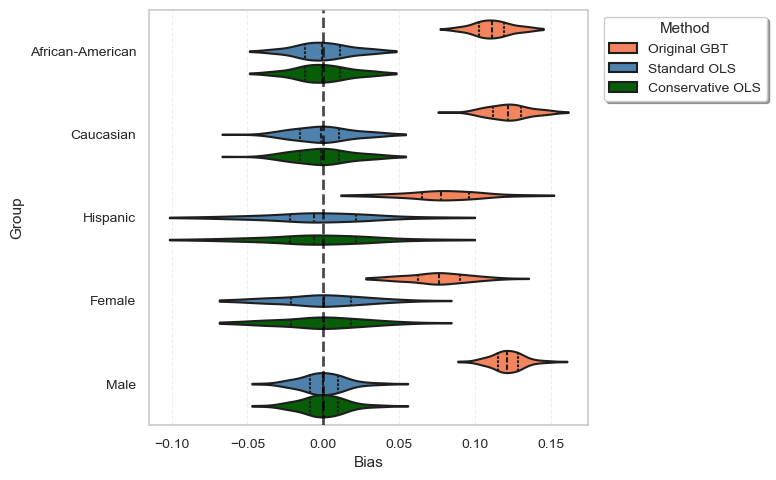


Summary Statistics: Bias Distribution Across Splits
Group                Method               Mean         Std          |Mean|      
----------------------------------------------------------------------------------------------------
African-American     Original GBT         +0.111539   0.012925   0.111539
                     Standard OLS         -0.000155   0.018558   0.000155
                     Conservative OLS     -0.000155   0.018558   0.000155
                     Reduction (Std)      +0.111384
                     Reduction (Cons)     +0.111384
----------------------------------------------------------------------------------------------------
Caucasian            Original GBT         +0.122282   0.014465   0.122282
                     Standard OLS         -0.000244   0.020591   0.000244
                     Conservative OLS     -0.000244   0.020591   0.000244
                     Reduction (Std)      +0.122038
                     Reduction (Cons)     +0.122038
------------

In [ ]:
# Run train-test splits and collect per-group bias results
results = run_train_test_splits(
    X, y, f, races, sexes, order_races, order_sexes, beta_hat,
    n_splits=100, test_size=0.3, lam=0.01, verbose=True
)

# Convert results to DataFrame for plotting
df_plot = results_to_dataframe(results, order_races, order_sexes)
all_groups = order_races + order_sexes

# Set up seaborn style
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

# Create color palette (matching ImageNet experiments)
colors = {
    'Original GBT': 'coral',
    'Standard OLS': 'steelblue',
    'Conservative OLS': 'darkgreen'
}

# Create single violin plot (compressed vertically for paper)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Define order for methods
method_order = ['Original GBT', 'Standard OLS', 'Conservative OLS']

# Create violin plot
sns.violinplot(
    data=df_plot,
    x='Bias',
    y='Group',
    hue='Method',
    order=all_groups,
    hue_order=method_order,
    palette=colors,
    orient='h',
    ax=ax,
    inner='quartile',
    linewidth=1.5,
    saturation=0.85,
    cut=0
)

# Add zero line
ax.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.7, zorder=10)

# Styling
ax.set_xlabel('Bias', fontsize=11)
ax.set_ylabel('Group', fontsize=11)
ax.tick_params(axis='both', labelsize=10)
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.8)

# Move legend outside the plot
ax.legend(title='Method', fontsize=10, title_fontsize=11, 
         bbox_to_anchor=(1.02, 1), loc='upper left',
         frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

# Print summary statistics
print_summary_statistics(results, order_races, order_sexes)